In [ ]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 48.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Encoding and Tokenizing Label

In [ ]:
train_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/train_df.pkl')
validation_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/validation_df.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/test_df.pkl')

In [ ]:
# getting the training, validation, and test text
train_text = train_df['lyrics'].tolist()
validation_text = validation_df['lyrics'].tolist()
test_text = test_df['lyrics'].tolist()

In [ ]:
# getting the training, validation, and test label
train_label = train_df['mapped_genres'].tolist()
validation_label = validation_df['mapped_genres'].tolist()
test_label = test_df['mapped_genres'].tolist()

In [ ]:
# getting rid of \n in the lyrics column
def preprocess_text(text):
  return text.replace('\n', ' ')

train_text = [preprocess_text(text) for text in train_text]
validation_text = [preprocess_text(text) for text in validation_text]
test_text = [preprocess_text(text) for text in test_text]

In [ ]:
# encoding the labels
encode_label = LabelEncoder()
train_label = encode_label.fit_transform(train_label)
validation_label = encode_label.fit_transform(validation_label)
test_label = encode_label.fit_transform(test_label)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40384 entries, 0 to 40383
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             40384 non-null  object 
 1   genres         40384 non-null  object 
 2   tags           40384 non-null  object 
 3   lang           40384 non-null  object 
 4   artist         40384 non-null  object 
 5   song           40384 non-null  object 
 6   album_name     40384 non-null  object 
 7   spotify_id     40384 non-null  object 
 8   popularity     40384 non-null  float64
 9   release        40384 non-null  int64  
 10  danceability   40384 non-null  float64
 11  energy         40384 non-null  float64
 12  key            40384 non-null  float64
 13  mode           40384 non-null  float64
 14  valence        40384 non-null  float64
 15  tempo          40384 non-null  float64
 16  duration_ms    40384 non-null  int64  
 17  mapped_genres  40384 non-null  object 
 18  lyrics

In [ ]:
train_df.head()

,id,genres,tags,lang,artist,song,album_name,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms,mapped_genres,lyrics_id,lyrics
0,0YBEBBsvEhueTFKs,"[metal, alternative metal, alternative rock, n...","[metal, alternative metal, deftones, alternati...",en,Deftones,Deathblow,Deftones,09QuitJuAP87RoBSpiCXPs,37.0,2003,0.556,0.6890,8.0,0.0,0.383,128.064,328173,Alternative,0YBEBBsvEhueTFKs,Soon as you came in all the beast went away\nT...
1,iyxKHmSwk4upK59f,"[rock, classic rock, hard rock]","[rock, classic rock, queen, hard rock]",en,Queen,Ride the Wild Wind,Innuendo,7rkrEyowp24CGvy0vE3snq,22.0,1991,0.566,0.6950,5.0,1.0,0.376,113.808,281440,Rock,iyxKHmSwk4upK59f,"Ride the wild wind\n(Push the envelope, don't ..."
2,Pt8zYJlZoAfSrJVD,[rap],"[trap, rap, hip-hop, rnb]",en,YNW Melly,Rolling Loud,We All Shine,1wX1DO1MBKec6DeWpTe6fM,57.0,2019,0.764,0.4740,9.0,1.0,0.151,132.005,204544,Hip Hop & Rap,Pt8zYJlZoAfSrJVD,"Hey, hey\nYou know the mountains and the sun f..."
3,NnsTQ8qIJeARR2PX,[rock],"[rock, holiday]",en,Ash,Pacific Palisades,Free All Angels,5tvLu5uwx0ObRyJgOCZjX5,12.0,1998,0.356,0.9760,2.0,1.0,0.566,168.428,116760,Rock,NnsTQ8qIJeARR2PX,You were standing on the shore\nListening to t...
4,0hhgAPscs36TcQI6,[folk],"[folk, songs, guud]",en,Mount Eerie,I Have Been Told That My Skin Is Exceptionally...,Dawn,57rro2VcnlGgDu9l7QWXic,17.0,2004,0.483,0.0519,9.0,1.0,0.232,101.548,101707,Country & Folk,0hhgAPscs36TcQI6,Should there be songs?\nShould my hair be long...


In [ ]:
# initializeing TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features= 10000)

# fit and transform the text
X_train = tfidf_vectorizer.fit_transform(train_text)
X_val = tfidf_vectorizer.transform(validation_text)
X_test = tfidf_vectorizer.transform(test_text)

In [ ]:
# scaling tf-idf feature
scaler = StandardScaler(with_mean = False)
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

# Multi-Modal data prep

In [ ]:
train_df['lyric_length'] = train_df.lyrics.apply(lambda x: len(x.split()))
validation_df['lyric_length'] = validation_df.lyrics.apply(lambda x: len(x.split()))
test_df['lyric_length'] = test_df.lyrics.apply(lambda x: len(x.split()))

In [ ]:
numerical_features = ['popularity', 'release', 'danceability', 'energy', 'key', 'mode', 'valence', 'tempo', 'duration_ms', 'lyric_length']

# scaling numerical features
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(train_df[numerical_features])
X_val_scale = scaler.transform(validation_df[numerical_features])
X_test_scale = scaler.transform(test_df[numerical_features])

<Axes: >

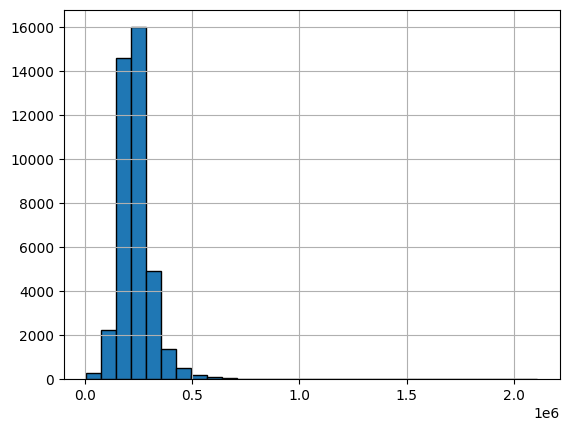

In [ ]:
train_df['duration_ms'].hist(bins=30, edgecolor='black')

# Bert Embedding

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

#X_train_bert = np.array([get_bert_embedding(text) for text in train_text])
#X_val_bert = np.array([get_bert_embedding(text) for text in validation_text])
#X_test_bert = np.array([get_bert_embedding(text) for text in test_text])

#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert.npy', X_train_bert)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_val_bert.npy', X_val_bert)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_test_bert.npy', X_test_bert)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
chunks = np.array_split(train_text, 5)

In [ ]:
#X_train_bert_0 = np.array([get_bert_embedding(text) for text in chunks[0]])
#X_train_bert_1 = np.array([get_bert_embedding(text) for text in chunks[1]])
#X_train_bert_2 = np.array([get_bert_embedding(text) for text in chunks[2]])
#X_train_bert_3 = np.array([get_bert_embedding(text) for text in chunks[3]])
#X_train_bert_4 = np.array([get_bert_embedding(text) for text in chunks[4]])

#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_0.npy', X_train_bert_0)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_1.npy', X_train_bert_1)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_2.npy', X_train_bert_2)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_3.npy', X_train_bert_3)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_4.npy', X_train_bert_4)

In [ ]:
X_train_bert = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert.npy')
X_val_bert = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_val_bert.npy')
X_test_bert = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_test_bert.npy')

In [ ]:
#X_train_bert_0 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_0.npy')
#X_train_bert_1 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_1.npy')
#X_train_bert_2 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_2.npy')
#X_train_bert_3 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_3.npy')
#X_train_bert_4 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_4.npy')

In [ ]:
#X_train_bert_0 = np.squeeze(X_train_bert_0, axis=1)
#X_train_bert_1 = np.squeeze(X_train_bert_1, axis=1)
#X_train_bert_2 = np.squeeze(X_train_bert_2, axis=1)
#X_train_bert_3 = np.squeeze(X_train_bert_3, axis=1)
#X_train_bert_4 = np.squeeze(X_train_bert_4, axis=1)

In [ ]:
#X_train_bert = np.concatenate([X_train_bert_0, X_train_bert_1, X_train_bert_2, X_train_bert_3, X_train_bert_4])

In [ ]:
#X_train_bert = np.squeeze(X_train_bert, axis=1)
X_val_bert = np.squeeze(X_val_bert, axis=1)
X_test_bert = np.squeeze(X_test_bert, axis=1)

In [ ]:
X_train_bert = np.hstack((X_train_scale, X_train_bert))
X_val_bert = np.hstack((X_val_scale, X_val_bert))
X_test_bert = np.hstack((X_test_scale, X_test_bert))

In [ ]:
# initalizing logistic regression for baseline model
logreg_model = LogisticRegression(max_iter=5000, solver='liblinear')

# fitting the model
logreg_model.fit(X_train_bert, train_label)
#logreg_model.fit(X_val_bert, validation_label)    #just testing bert embeddings before loading all for training set

# evalutating the baseline model for test set
train_predict = logreg_model.predict(X_train_bert)
train_accuracy = accuracy_score(train_label, train_predict)
print(f'Train Accuracy: {train_accuracy}')

#evaluation the baseline model for validation set
val_predict = logreg_model.predict(X_val_bert)
val_accuracy = accuracy_score(validation_label, val_predict)
print(f'Validation Accuracy:{val_accuracy}')

Train Accuracy: 0.5932299920760697
Validation Accuracy:0.5600237717908082


### Numerical Logistic Regression

In [ ]:
# initalizing logistic regression for baseline model
logreg_model = LogisticRegression(max_iter=5000, solver='liblinear')

# fitting the model
logreg_model.fit(X_train_scale, train_label)
#logreg_model.fit(X_val_bert, validation_label)    #just testing bert embeddings before loading all for training set

# evalutating the baseline model for test set
train_predict = logreg_model.predict(X_train_scale)
train_accuracy = accuracy_score(train_label, train_predict)
print(f'Train Accuracy: {train_accuracy}')

#evaluation the baseline model for validation set
val_predict = logreg_model.predict(X_val_scale)
val_accuracy = accuracy_score(validation_label, val_predict)
print(f'Validation Accuracy:{val_accuracy}')

Train Accuracy: 0.47516343106180664
Validation Accuracy:0.48851030110935023


# EVALUATION

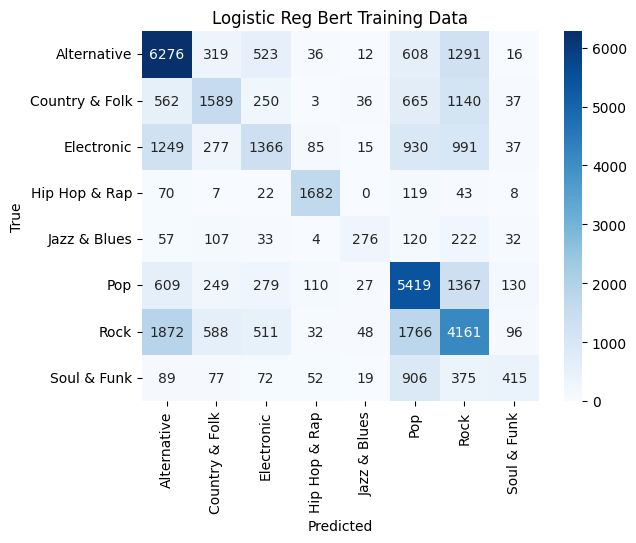

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

cm = confusion_matrix(train_label, train_predict)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg Bert Training Data')
plt.show()

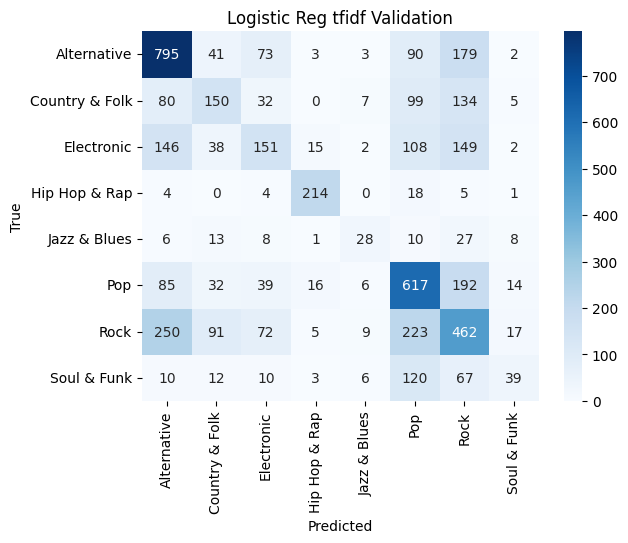

In [ ]:
cm = confusion_matrix(validation_label, val_predict)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg tfidf Validation')
plt.show()